#Resources
**Image Super-Resolution Using Deep Convolutional Networks", presented in ECCV 2014**

[Colab+SR metrics](https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html)

[Code-link-2](https://shritesh99.github.io/Image_Super_Resolution/)

#Mount drive

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Config

In [71]:
set_batch = 64
set_epoch = 200

dir_master = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset"
dir_yTrain = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/yTrain"
dir_yTest = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/yTest"
dir_train = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/Train"
dir_test = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/Test"
dir_output = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/output"
dir_resized = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/resized"
dir_save_model = "/content/drive/MyDrive/CODE/5th sem project/ISR-dataset-3/SRCNN_dataset/models"

#Import lib

In [72]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

In [73]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Numpy: 1.21.6
Pandas: 1.3.5
OpenCV: 4.6.0
Tensorflow: 2.9.2
Matplotlib: 3.2.2
Scikit-Image: 0.18.3


#Metric Functions

Actually, when we saw the raw image, we cannot make sure that this image is whether high resolution image or not. There are several metrics to measure image quality,

1.   Peak Signal-to-Noise Ratio (PSNR)
2.   Mean Squared Error (MSE)
3.   Strucutural Similarity (SSIM)

**PSNR** is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation.

**SSIM** is a method for predicting the perceived quality, and it is used for measureing the similarity between two images. If this value is close to 1, then two images are identical. Otherwise, two images will be totally different.

#Peak Signal-to-Noise Ratio (PSNR)

In [74]:
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

#Mean Squared Error (MSE)

In [75]:
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

#Strucutural Similarity

In [76]:
from skimage.metrics import structural_similarity as ssim

We defined our metrics for measuring image quality, we need to combine whole metrics in one metric.

#Combines all three image quality metrics

In [77]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

#Prepare distorted images via resizing

Download image folder(named **Train** and **Test**) into new directory **(dataset\SRCNN_dataset)**

Then to make **distorted image** from the raw data. 

1.  *Original image -> Down resize image*
2.  *Down resized image -> Up to original (W×H)* //the resolution will be lower since the pixel information may loss during resize.

In [78]:
def prepare_images(path, factor):
    # Loop through the files in the directory
    for file in os.listdir(path):
        image = cv2.imread(path + '/' + file)
        
        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # Resize down the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # Resize up the image
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Save the image
        try:
            os.listdir(dir_resized)
        except:
            os.mkdir(dir_resized)
        # save the image
        print('Saving {}'.format(file))    
        cv2.imwrite(dir_resized + '/{}'.format(file), image)

#Check Loaded data

In [79]:
prepare_images(dir_master+'/Test/Set14', 2)

Saving ppt3.bmp
Saving foreman.bmp
Saving baboon.bmp
Saving flowers.bmp
Saving pepper.bmp
Saving barbara.bmp
Saving coastguard.bmp
Saving man.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving zebra.bmp
Saving bridge.bmp
Saving face.bmp
Saving comic.bmp


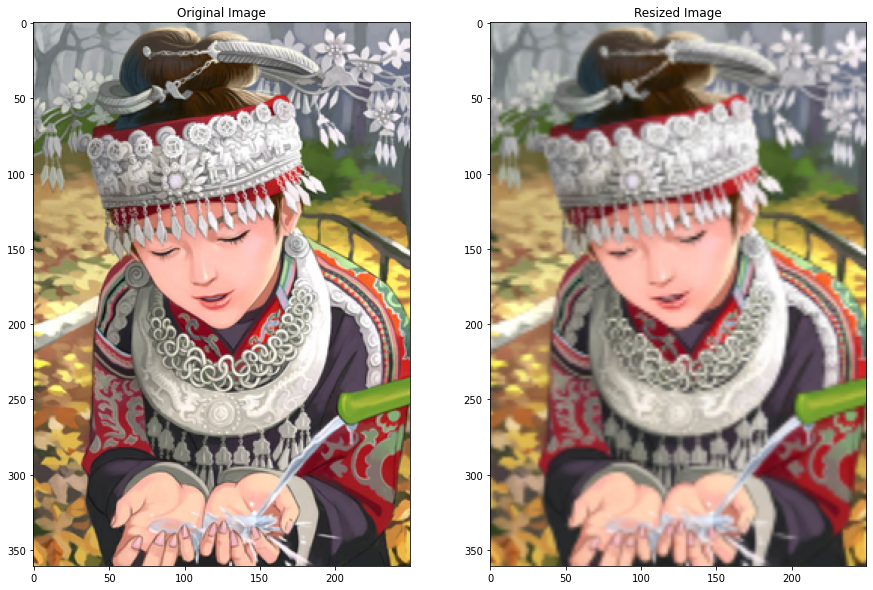

In [80]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open(dir_master+'/Test/Set14/comic.bmp'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open(dir_master+'/resized/comic.bmp'))
ax[1].title.set_text('Resized Image')
plt.show()

#Check Metrics

In [81]:
for file in os.listdir(dir_master +'/Test/Set14/'):
    
    # open target and reference images
    target = cv2.imread(dir_master +'/Test/Set14/{}'.format(file))
    ref = cv2.imread(dir_master +'/resized/{}'.format(file))

    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

<ipython-input-75-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


ppt3.bmp
PSNR: 24.84926108922759
MSE: 638.66849555074
SSIM: 0.9284023942315316

foreman.bmp
PSNR: 30.14456552968924
MSE: 188.6883483270202
SSIM: 0.933268417388899

baboon.bmp
PSNR: 22.157083766614214
MSE: 1187.1162666666667
SSIM: 0.629277587900277

flowers.bmp
PSNR: 27.454503954087876
MSE: 350.55098342541436
SSIM: 0.8697286286974628

pepper.bmp
PSNR: 29.889471550750773
MSE: 200.1033935546875
SSIM: 0.8357937568464359

barbara.bmp
PSNR: 25.906629181292335
MSE: 500.6551697530864
SSIM: 0.8098632646406401

coastguard.bmp
PSNR: 27.161600551854495
MSE: 375.00887784090907
SSIM: 0.756950063354931

man.bmp
PSNR: 27.226462631039823
MSE: 369.4497375488281
SSIM: 0.8214950645456561

lenna.bmp
PSNR: 31.47349264931913
MSE: 138.94801330566406
SSIM: 0.8460989200521499

monarch.bmp
PSNR: 30.196242385526865
MSE: 186.4564208984375
SSIM: 0.9439574293434104

zebra.bmp
PSNR: 27.909840108528776
MSE: 315.65856341052523
SSIM: 0.8911656209329116

bridge.bmp
PSNR: 25.850528480005014
MSE: 507.1643981933594
SSIM: 0.

#Augment [Train | Test] dataset build

#Train DS

In [82]:
# Build train dataset
import h5py

names = sorted(os.listdir(dir_master+'/Train'))

data = []
label = []

for name in names:
    fpath = dir_master+'/Train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)
    
    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16
            
            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]
            
            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.
            
            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)
            
            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch
            
            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

#Read [a prior build dataset with h5 format]

In [83]:
with h5py.File(dir_master+'/train_catvnoncat.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

#Test DS

In [84]:
# Build test dataset

names = sorted(os.listdir(dir_master+'/Test/Set14'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = dir_master+'/Test/Set14/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    
    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        
        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.
        
        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

In [85]:
with h5py.File(dir_master+'/test_catvnoncat.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

#**Multi-scale Residual Network**

In [86]:
from keras.layers import Conv2D, Add, Input
from keras.models import Model

# Define the MSRNet model architecture
def build_msrnet_model():
    # Define the input layer
    input_shape = (None, None, 1)
    inputs = Input(shape=input_shape)
    
    # Define the first residual block
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = Add()([inputs, x])
    
    # Define the second residual block
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = Add()([inputs, x])
    
    # Define the third residual block
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = Add()([inputs, x])
    
    # Define the multi-scale skip connections
    x1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(inputs)
    x2 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x1)
    x3 = Conv2D(filters=64, kernel_size=7, strides=1, padding='same', use_bias=True, kernel_initializer='glorot_uniform', activation='relu')(x2)
    x = Add()([x, x1, x2, x3])
    
    # Define the output layer
    outputs = Conv2D(filters=3, kernel_size=1, strides=1, padding='same', activation='tanh')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model_msrnet = build_msrnet_model()
# Compile the model
model_msrnet.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_72 (Conv2D)             (None, None, None,   640         ['input_8[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_73 (Conv2D)             (None, None, None,   36928       ['conv2d_72[0][0]']              
                                64)                                                         

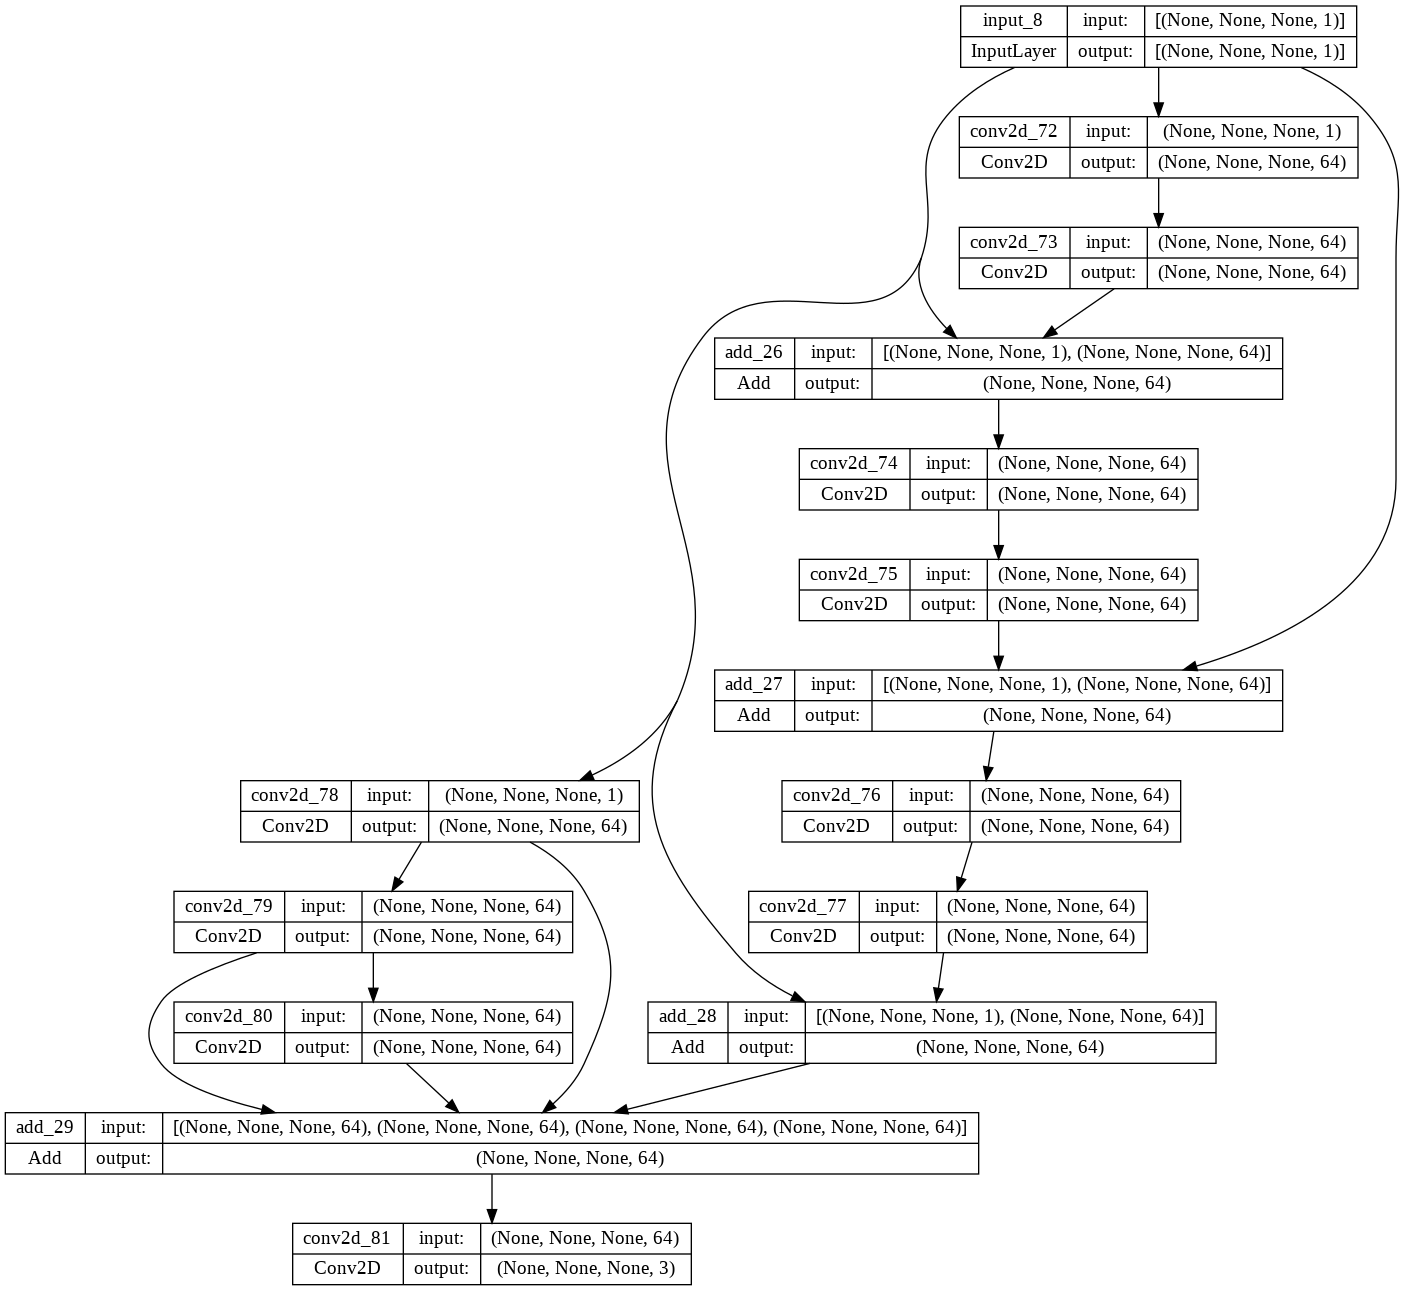

In [87]:
model_msrnet.summary()
keras.utils.plot_model(model_msrnet,"MSRNET Model.png", show_shapes=True)

#**Build SR-CNN Model**

Already prepared our dataset into **h5 format**. We will build **SR-CNN with sequential model**.

In [88]:
def sr_cnn_model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

#Train the model

In [89]:
model_srcnn = sr_cnn_model() #model_msrnet #
model_srcnn.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, None, None, 128)   10496     
                                                                 
 conv2d_83 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_84 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


#Load h5 <Train, Test> dataset 
Then we load the dataset from prebuilt h5 file

In [90]:
with h5py.File(dir_master+'/train_catvnoncat.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))
    
with h5py.File(dir_master+'/test_catvnoncat.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14901, 32, 32, 1), (14901, 20, 20, 1), (420, 32, 32, 1), (420, 20, 20, 1))

In [91]:
checkpoint_path = dir_master+'/model/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [92]:
model_srcnn.fit(X_train, y_train, batch_size= set_batch, validation_data=(X_test, y_test), callbacks=[checkpoint], shuffle=True, epochs=set_epoch, verbose=False)
# model_msrnet.fit(X_train, X_train, batch_size= set_batch, validation_data=(X_test, X_test), shuffle=True, epochs=set_epoch, verbose=False)

#Save the model

In [93]:
def save_sr_model(model_name):
    modelSavePath = dir_save_model
    import time
    t = time.time()
    outPath = "/{}.h5".format(int(t))
    totalModelPath = modelSavePath+outPath
    print(totalModelPath)
    model_name.save(totalModelPath)

#Predict image from model

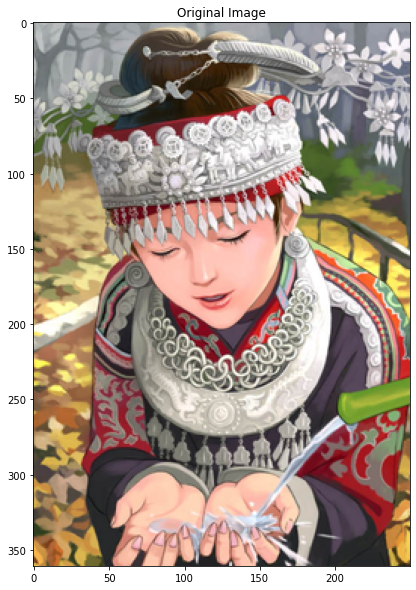

In [94]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open(dir_master+'/Test/Set14/comic.bmp'))
ax.title.set_text("Original Image")
plt.show()

#Distort image

Now, we need to **distort** the image by **resizing down and up**

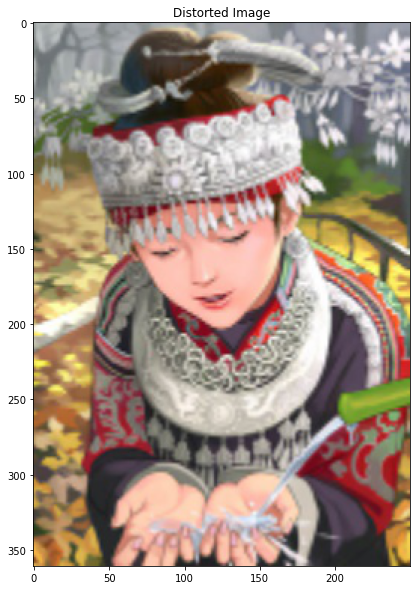

In [95]:
try:
    os.listdir(dir_master+'/output')
except:
    os.mkdir(dir_master+'/output')

target = cv2.imread(dir_master+'/Test/Set14/comic.bmp', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(dir_master+'/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open(dir_master+'/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

#Predict SR image

1/1 [==============================] - 0s 52ms/step


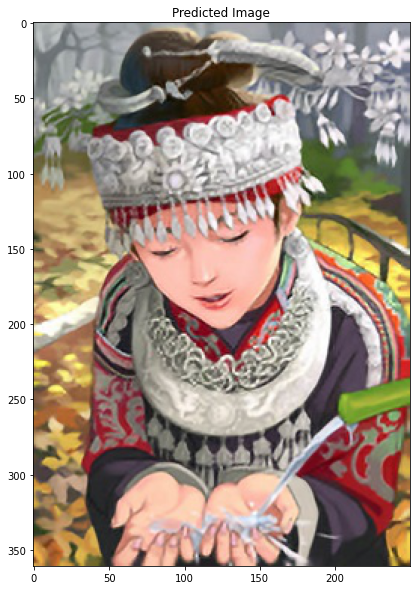

In [96]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = model_srcnn.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite(dir_master+'/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open(dir_master+'/output/output.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

#Save best model

In [97]:
# save_sr_model(model_srcnn)

#Compare all those images [Original | Distort | Predict]

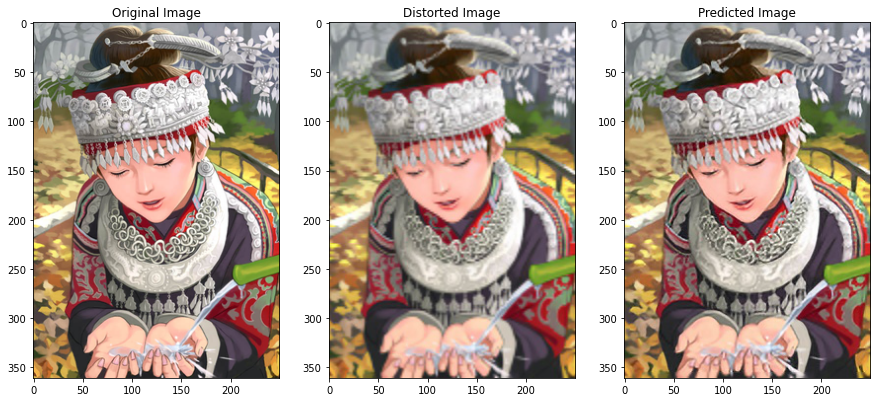

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open(dir_master+'/Test/Set14/comic.bmp'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open(dir_master+'/output/input.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open(dir_master+'/output/output.jpg'))
ax[2].title.set_text("Predicted Image")

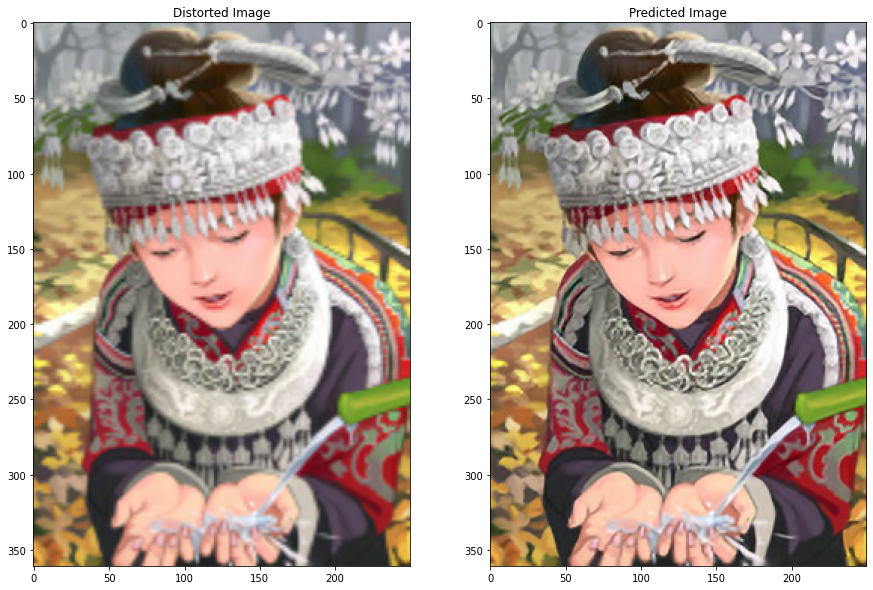

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open(dir_master+'/output/input.jpg'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open(dir_master+'/output/output.jpg'))
ax[1].title.set_text("Predicted Image")

#Metric Comparison <Final>

In [100]:
original = cv2.imread(dir_master+'/Test/Set14/comic.bmp')
distorted = cv2.imread(dir_master+'/output/input.jpg')
predicted = cv2.imread(dir_master+'/output/output.jpg')

In [101]:
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 23.710178081443786
MSE: 830.2020609418282
SSIM: 0.8259338375271387


<ipython-input-75-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


In [102]:
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 25.507704383911584
MSE: 548.8215844875347
SSIM: 0.8861875292695194


<ipython-input-75-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


#Conclusion

We can see that **Peak Signal to Noise Ratio (PSNR)** of predicted image is higher than that of distorted image, and same in **Structural Similarity (SSIM)**. As a result, it concludes that **SR-CNN model** can **enhance the image quality**, and the *predicted output is more similar with original image*.

#Load the saved Model

[1] SR_with_2000epoch

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


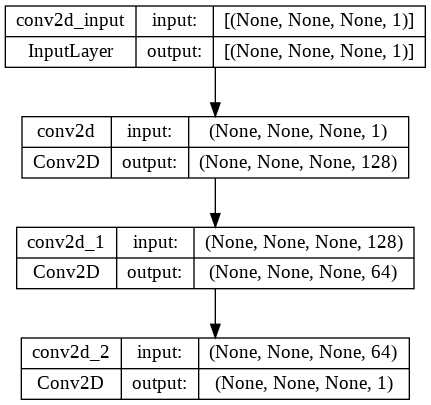

In [103]:
from tensorflow import keras
modelPath = dir_save_model+'/SR_with_2000epoch.h5'
loadModel = keras.models.load_model(modelPath)
loadModel.summary()
#print in/out Model as images
keras.utils.plot_model(loadModel,"SR Model.png", show_shapes=True)